In [1]:
from transformers import MarianMTModel, MarianTokenizer
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk import sent_tokenize, word_tokenize, stem
from transformers import BertTokenizer, BertModel
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import dictdiffer
from colorama import *

c:\Users\nikla\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In diesem Notebook geht es darum ein vortrainiertes Model einen bekannten Text übersetzen zu lassen und diesen mit einer menschlichen Übersetzung zu vergleichen.

Zunächst wird das Model und der entsprechende Tokenaizer importiert. 

In [2]:
model_name = "Helsinki-NLP/opus-mt-de-en"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

device = "cuda" if torch.cuda.is_available() else "cpu" #Verschieben der Daten auf die GPU
model.to(device)

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(58101, 512, padding_idx=58100)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(58101, 512, padding_idx=58100)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLU()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=1e-05

Laden des Textes der übersetzt werden soll. In diesem Fall die erste Seite von "Die Verwandlung" von Franz Kafka.

In [3]:
with open("Kafka.txt", "r", encoding="utf-8") as file: 
    ger_Kafka = file.read()

print(ger_Kafka)

Als Gregor Samsa eines Morgens aus unruhigen Träumen erwachte, fand er sich in seinem Bett zu einem ungeheueren Ungeziefer verwandelt. Er lag auf seinem panzerartig harten Rücken und sah, wenn er den Kopf ein wenig hob, seinen gewölbten, braunen, von bogenförmigen Versteifungen geteilten Bauch, auf dessen Höhe sich die Bettdecke, zum gänzlichen Niedergleiten bereit, kaum noch erhalten konnte. Seine vielen, im Vergleich zu seinem sonstigen Umfang kläglich dünnen Beine flimmerten ihm hilflos vor den Augen.
»Was ist mit mir geschehen?« dachte er. Es war kein Traum. Sein Zimmer, ein richtiges, nur etwas zu kleines Menschenzimmer, lag ruhig zwischen den vier wohlbekannten Wänden. Über dem Tisch, auf dem eine auseinandergepackte Musterkollektion von Tuchwaren ausgebreitet war – Samsa war Reisender –, hing das Bild, das er vor kurzem aus einer illustrierten Zeitschrift ausgeschnitten und in einem hübschen, vergoldeten Rahmen untergebracht hatte. Es stellte eine Dame dar, die, mit einem Pelzhu

Text wird in Sätze aufgeteilt. 

In [4]:
sentences = sent_tokenize(ger_Kafka, language="german")

print(f"Anzahl der Sätze: {len(sentences)}")
print(sentences)

Anzahl der Sätze: 16
['Als Gregor Samsa eines Morgens aus unruhigen Träumen erwachte, fand er sich in seinem Bett zu einem ungeheueren Ungeziefer verwandelt.', 'Er lag auf seinem panzerartig harten Rücken und sah, wenn er den Kopf ein wenig hob, seinen gewölbten, braunen, von bogenförmigen Versteifungen geteilten Bauch, auf dessen Höhe sich die Bettdecke, zum gänzlichen Niedergleiten bereit, kaum noch erhalten konnte.', 'Seine vielen, im Vergleich zu seinem sonstigen Umfang kläglich dünnen Beine flimmerten ihm hilflos vor den Augen.', '»Was ist mit mir geschehen?« dachte er.', 'Es war kein Traum.', 'Sein Zimmer, ein richtiges, nur etwas zu kleines Menschenzimmer, lag ruhig zwischen den vier wohlbekannten Wänden.', 'Über dem Tisch, auf dem eine auseinandergepackte Musterkollektion von Tuchwaren ausgebreitet war – Samsa war Reisender –, hing das Bild, das er vor kurzem aus einer illustrierten Zeitschrift ausgeschnitten und in einem hübschen, vergoldeten Rahmen untergebracht hatte.', 'Es 

Die einzelnen Sätze werden einzeln tokeniziert und das Model erzeugt eine Übersetzung.

In [5]:
translated_sentences = []

for sentence in sentences:
    # Text vorbereiten und übersetzen
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True)
    inputs = inputs.to(device)
    translated = model.generate(**inputs) # **wird zum entpacken benötigt
    translation = tokenizer.decode(translated[0], skip_special_tokens=True)
    translated_sentences.append(translation)


translated_text = "\n".join(translated_sentences) # Übersetzung wird in zusammenhängenden String convertiert. 
print(translated_text)

One morning, when Gregor Samsa awoke from troubled dreams, he found himself transformed into an enormous vermin in his bed.
He lay on his armor-like hard back and saw, when he lifted his head a little, his arched brown belly, divided by arch-shaped stiffenings, on the height of which the duvet, ready for complete gliding down, could hardly get any more.
His many legs shimmered helplessly in front of his eyes compared to his other circumference.
'What happened to me?' he thought.
It wasn't a dream.
His room, a real, just a little too small human room, lay quietly between the four well-known walls.
Above the table, on which a packed sample collection of cloth articles was spread – Samsa was a traveller – hung the picture that he had recently cut out from an illustrated magazine and placed in a pretty gilded frame.
It represented a lady who, with a fur hat and a fur boa, sat upright and raised a heavy fur muff, in which her whole forearm had disappeared, to the spectator.
Gregor's gaze th

Die menschliche Übersetzung wird eingelesen.

In [6]:
with open("Kafka_eng.txt", "r", encoding="utf-8") as file: # r steht für read
    eng_Kafka = file.read()

#print(eng_Kafka)
eng_Kafka_sentences = sent_tokenize(eng_Kafka, language="english")
print(eng_Kafka_sentences)
print(translated_sentences)



['One morning, when Gregor Samsa woke from troubled dreams, he found himself transformed in his bed into a horrible vermin.', 'He lay on his armour-like back, and if he lifted his head a little he could see his brown belly, slightly domed and divided by arches into stiff sections.', 'The bedding was hardly able to cover it and seemed ready to slide off any moment.', 'His many legs, pitifully thin compared with the size of the rest of him, waved about helplessly as he looked.', '“What’s happened to me?” he thought.', 'It wasn’t a dream.', 'His room, a proper human room although a little too small, lay peacefully between its four familiar walls.', 'A collection of textile samples lay spread out on the table—Samsa was a travelling salesman—and above it there hung a picture that he had recently cut out of an illustrated magazine and housed in a nice, gilded frame.', 'It showed a lady fitted out with a fur hat and fur boa who sat upright, raising a heavy fur muff that covered the whole of h

Vergleich der Texte

Erste Vergleichsmethode ist die Cosinus Ähnlichkeit.
Dabei werden die beiden Texte in Vektoren umgewandelt und miteinander verglichen. 
Dies testet nur die Quanitative Ähnlichkeit der Texte.


In [7]:
vectorizer = TfidfVectorizer()
matrix = vectorizer.fit_transform([translated_text, eng_Kafka])
cosine_sim = cosine_similarity(matrix[0:1], matrix[1:2])
print(f"Cosinus-Ähnlichkeit: {cosine_sim[0][0]:.2f}")

Cosinus-Ähnlichkeit: 0.80


Ein Wert von 0.8 spricht für eine hohe Ähnlichkeit der Texte. 

Für die Bewertung semantische Bewertung wird ein vortrainiertes Bert Model genutzt. 

Das Model vergleicht den menschlich übersetzen Text mit dem maschinell übersetzen Text. 

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Tokenizieren der Texte 
def encode(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze()

# Embeddings bestimmen
embedding_trans_text = encode(translated_text)
embedding_eng = encode(eng_Kafka)
# Bestimmt den Winkel zwischen Embedidngs 
# Da Distanz bestimmt werden soll muss von 1 subtrahiert werden
similarity = 1 - cosine(embedding_trans_text.numpy(), embedding_eng.numpy()) 

print(f"Semantische Ähnlichkeit: {similarity:.2f}")

Semantische Ähnlichkeit: 0.97


Auch Bert bestimmt die Cosinus Ähnlichkeit. In diesem Fall von den beiden Embeddings der beiden Texte.

Mit 0.97 ist der Wert nochmal deutlich besser als nur von der Cosinuns Ähnlichkeit. 


Im nächsten Schritt wird die Jaccard Ähnlichkeit bestimmt.
Dabei wird die Anzahl der Wörter die in beiden Texten vorkommen, durch die Anzahl der Wörter die nur in einem der Texte geteilt.

In [9]:
human_tokens = word_tokenize(eng_Kafka)
machine_tokens = word_tokenize(translated_text)

inters_len = len(set(human_tokens).intersection(set(machine_tokens)))
union_len = len(set(human_tokens).union(set(machine_tokens)))
jaccard_sim = inters_len / union_len
    
print("Jaccard Ähnlichkeit:",jaccard_sim)

Jaccard Ähnlichkeit: 0.40789473684210525


Als nächsten wird bestimmt welche Wörter genau die beiden Übersetzungen gemeinsam haben und welche nur ein einer der beiden Übersetzungen vorkommen. 

In [10]:
# Texte in Wörter zerlegen
human_tokens = word_tokenize(eng_Kafka)
machine_tokens = word_tokenize(translated_text)

# Gemeinsame und unterschiedliche Wörter
common_tokens = set(machine_tokens).intersection(human_tokens)
unique_to_machine = set(machine_tokens) - common_tokens
unique_to_human = set(human_tokens) - common_tokens

print("Gemeinsame Wörter:", common_tokens)
print("Nur in maschineller Übersetzung:", unique_to_machine)
print("Nur in menschlicher Übersetzung:", unique_to_human)

Gemeinsame Wörter: {',', 'into', 'frame', 'threw', 'all', 'head', 'Samsa', 'could', 'because', 'that', 'worries', 'times', 'boa', 'dreams', 'small', 'transformed', 'back', 'walls', 'weather', 'made', 'so', 'dream', 'Gregor', 'by', 'upright', 'One', 'muff', 'morning', 'divided', 'Oh', 'belly', 'picture', 'strenuous', 'slight', 'one', 'feel', 'when', 'was', 'top', 'the', 'too', 'whole', 'present', 'which', 'hundred', 'lay', 'of', 'heavy', 'helplessly', 'turned', 'human', 'towards', 'his', 'His', 'irregular', 'hung', 'but', 'It', 'ready', 'any', 'be', 'he', 'in', 'more', 'pushed', 'little', 'go', 'bad', 'between', 'hat', 'troubled', 'recently', 'have', '?', 'lady', '!', 'from', 'at', 'brown', 'himself', 'He', 'business', 'food', 'The', 'lifted', 'get', 'many', 'hard', 'what', 'vermin', 'window', 'fur', 'I', 'hardly', 'who', 'than', 'illustrated', 'cold', 'bed', 'spread', 'a', 'four', 'state', 'connections', 'had', 'me', 'God', 'much', 'and', 'collection', 'this', 'eyes', 'sleeping', 'to',

Grafische Darstellung der Mengen

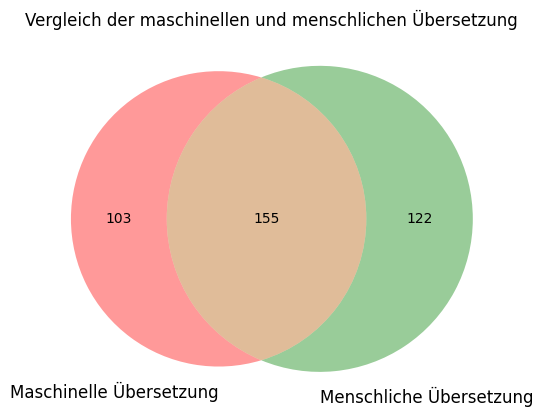

In [11]:
# Wortmengen bestimmen
common_tokens = set(machine_tokens).intersection(human_tokens)
unique_to_machine = set(machine_tokens) - common_tokens
unique_to_human = set(human_tokens) - common_tokens

# Venn-Diagramm erstellen
venn2(
    subsets=(len(unique_to_machine), len(unique_to_human), len(common_tokens)),
    set_labels=('Maschinelle Übersetzung', 'Menschliche Übersetzung')
)

plt.title("Vergleich der maschinellen und menschlichen Übersetzung")
plt.show()

Visualisierter Vergleich anhand von Beispielen

In [12]:
stemmer = stem.PorterStemmer()


# Liste mit wörten und Anzahl
def word_count(input: list) -> dict:
    dict = {}
    for word in input:
        dict[word] = input.count(word)
    return dict

# Vergleicht den Text visuell (Rot: geändertes Wort, Gelb: Anzahl ungleich)
def diff_text_count(input_a: str, input_b: str):
    # Tokenisierung
    a = word_tokenize(input_a)
    b = word_tokenize(input_b)

    # Word count
    dict_count_a = word_count(a)
    dict_count_b = word_count(b)

    # Vergleiche zwei Dictionarys
    diff = list(dictdiffer.diff(dict_count_a, dict_count_b))

    # Zähle Änderungen
    words_changed = []
    words_added = []
    words_removed = []

    # Füge wörte in die Änderungslisten
    for item in diff:
        if item[0] == 'change':
            words_changed.append(item[1])
        if item[0] == 'add':
            for add_item in item[2]:
                words_added.append(add_item[0])
        if item[0] == 'remove':
            for remove_item in item[2]:
                words_removed.append(remove_item[0])
    
    # Highlightling im Text
    print(Fore.BLUE + "A: " + Fore.RESET, end='')
    for word in a:
        if word in words_removed:
            print(Fore.RED + word + " " + Fore.RESET , end='')
        elif word in words_changed:
            print(Fore.YELLOW + word + " " + Fore.RESET, end='')
        else:
            print(word + " ", end='')
    print()
    print(Fore.BLUE + "B: " + Fore.RESET, end='')
    for word in b:
        if word in words_added:
            print(Fore.RED + word + " " + Fore.RESET , end='')
        elif word in words_changed:
            print(Fore.YELLOW + word + " " + Fore.RESET, end='')
        else:
            print(word + " ", end='')
    print()

Zwei Beispiele, um die Unterschiede zu visualisieren. Rot sind Wörter, welche unterschiedlich sind. Gelb sind Wörter, bei denen die Anzahl unterschiedlich ist.

In [13]:
for maschine_sentence, human_sentence in zip(translated_sentences[:2], eng_Kafka_sentences[:2]):
    diff_text_count(maschine_sentence, human_sentence)
    print()
    

A: One morning , when Gregor Samsa awoke from troubled dreams , he found himself transformed into an enormous vermin in his bed . 
B: One morning , when Gregor Samsa woke from troubled dreams , he found himself transformed in his bed into a horrible vermin . 

A: He lay on his armor-like hard back and saw , when he lifted his head a little , his arched brown belly , divided by arch-shaped stiffenings , on the height of which the duvet , ready for complete gliding down , could hardly get any more . 
B: He lay on his armour-like back , and if he lifted his head a little he could see his brown belly , slightly domed and divided by arches into stiff sections . 

